

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

## Установка зависимостей

In [ ]:
!pip install efficientnet_pytorch
!pip install albumentations

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=a0ae41a088647930407bda12e07db0967853032bc0ce3262aea75b378c0bd463
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
     |████████████████████████████████| 634kB 13.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=2986d8885820751e835ee0f56d4f722cd835dd5fbf31e59c89709038a50622d5
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
from google.colab import drive
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

# что то связанное с сериализацией данных
import pickle
# Что то связано с рисование картинок
from skimage import io
# Что то для мультипроцессинга
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
from matplotlib import colors, pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
torch.use_deterministic_algorithms(True)

# from efficientnet_pytorch import EfficientNet

import PIL
from PIL import Image
# import albumentations as A

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Подготавливаем хранилище данных

In [3]:
# Монитруем диск (необходимо при работе с гугл колабом)
drive.mount('/content/gdrive/', force_remount=True)

# Распаковываем архив с картинками 
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Mounted at /content/gdrive/


In [ ]:
!rm -f /simpsons/train/homer/pic1328.jpg
!rm -f /simpsons/train/homer/pic0228.jpg
!rm -f /simpsons/train/homer/pic0632.jpg

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']

# Указываем путь до папок с трейном и тестом
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

# Указываем пути до конкретный файлов
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# Формируем список лейблов
train_val_labels = [path.parent.name for path in train_val_files]
n_classes = len(np.unique(train_val_labels))

In [ ]:
# oversampling
def create_dct_path_labels(train_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")
        
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path = create_dct_path_labels(train_val_files, train_val_labels)

# Дополним картинки классов у которых менее 75 картинок, до 75 картинок в классе
for person in dct_path:
    if len(dct_path[person]) < 75:
        dct_path[person] = dct_path[person] * (75 // len(dct_path[person]))
        dct_path[person].extend(dct_path[person][:75 - len(dct_path[person])])

for person in dct_path:
    print(f"{person}\t{len(dct_path[person])}")
        
train_val_files = []

for person in dct_path:
    train_val_files.extend(dct_path[person])

train_val_labels = [path.parent.name for path in train_val_files]

# Делим датасет на стратифицированный трейн и сплит
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

abraham_grampa_simpson	913
agnes_skinner	75
apu_nahasapeemapetilon	623
barney_gumble	106
bart_simpson	1342
carl_carlson	98
charles_montgomery_burns	1193
chief_wiggum	986
cletus_spuckler	75
comic_book_guy	469
disco_stu	75
edna_krabappel	457
fat_tony	75
gil	75
groundskeeper_willie	121
homer_simpson	2246
kent_brockman	498
krusty_the_clown	1206
lenny_leonard	310
lionel_hutz	75
lisa_simpson	1354
maggie_simpson	128
marge_simpson	1291
martin_prince	75
mayor_quimby	246
milhouse_van_houten	1079
miss_hoover	75
moe_szyslak	1452
ned_flanders	1454
nelson_muntz	358
otto_mann	75
patty_bouvier	75
principal_skinner	1194
professor_john_frink	75
rainier_wolfcastle	75
ralph_wiggum	89
selma_bouvier	103
sideshow_bob	877
sideshow_mel	75
snake_jailbird	75
troy_mcclure	75
waylon_smithers	181


In [ ]:
# Проверяем нличие гпу
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Устанавливаем девайс
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi

Mon Apr 26 15:14:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Описываем функции и классы

In [ ]:
# Датасет с аугментациями
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    # Получаем на вход список путей к файлам, которые нужно подгрузить *files*
    # А также указываем какой тип датасета мы используем *DATA_MODES*
    def __init__(self, files, mode, input_size):
        super().__init__()
        self.input_size = input_size
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
        # Определяем переменную для метода длины датасета
        self.len_ = len(self.files)
        
        # Определяем LabelEncoder, который по имени картинки преобразует ее в число
        self.label_encoder = LabelEncoder()
        
        # Лейблы тестового набора фалов не известны 
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            
            # тут мы пользуемся странной библиотекой
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # Тут мы открываем нашу картинку
        image = Image.open(file)
        # Выгружаем пиксели
        image.load()
        return image

    # Будем добавлять паддинг для того, чтобы картинка оставалась пропорциональной
    def prepare_sample(self, image):

        H = image.size[1]
        W = image.size[0]
        
        if H>W:
            image = transforms.functional.pad(image,padding=[round(abs(H-W)/2),0])
        else:
            image = transforms.functional.pad(image,padding=[0,round(abs(H-W)/2)])
            
        return image
    
    def augmentation_pipline(self, image):
        """Аугментирующие трансформации для трейна"""
        
        image = np.asarray(image)
        
        augmentation_pipeline = A.Compose(
            [
                A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
                A.OneOf(
                    [
                        # apply one of transforms to 50% of images
                        A.RandomContrast(limit=0.15), # apply contrast
                        A.RandomGamma(), # apply random gamma
                        A.RandomBrightness(limit=0.15), # apply brightness
                    ],
                    p = 0.5
                ),
                A.OneOf(
                    [
                        # apply one of transforms to 50% images
                        # A.ElasticTransform(
                        #     alpha = 120,
                        #     sigma = 120 * 0.09,
                        #     alpha_affine = 120 * 0.03
                        # ),
                        A.GridDistortion()
                        # A.OpticalDistortion(
                        #     distort_limit = 1.6,
                        #     shift_limit = 0.5
                        # )
                    ],
                    p = 0.5
                ),
                
            ],
            p = 1
        )
        
        image = augmentation_pipeline(image = image)
        image = Image.fromarray(image["image"])
        return image
  
    def __getitem__(self, index):
        # Перевод в нужный размер и в тензоры
        transform_train = transforms.Compose([
            transforms.Resize(size=(self.input_size, self.input_size)),
            transforms.RandomRotation(degrees=1),
            transforms.ToTensor(), # переводит в интервал от 0 до 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        transform_test = transforms.Compose([
            transforms.Resize(size=(self.input_size, self.input_size)),
            transforms.ToTensor(), # переводит в интервал от 0 до 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        # Загружаем картинку по пути, используя конкретный индекс
        x = self.load_sample(self.files[index])
        
        # Если тест, то лейблы не нужны
        if self.mode == 'test':
            x = self.prepare_sample(x)
            x = transform_test(x)
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            x = self.prepare_sample(x)
            x = self.augmentation_pipline(x)
            x = transform_train(x)
            return x, y

In [ ]:
# Подбор оптимального lr 
import math
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True, classic=False):
    """Слегка модифицированная функция для поиска оптимального learning rate 
    функция взята из замечатлеьной книги книги "Ian Pointer - Programming PyTorch
    for Deep Learning - Creating and Deploying Deep Learning Applications-
    O’Reilly Media (2019)
    """
    model.train()
    number_in_epoch = len(dataloaders['train']) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders['train']:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        if classic:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        else:
            outputs, aux_out = model(inputs)
            loss_1 = loss_fn(outputs, labels)
            loss_2 = loss_fn(aux_out, labels)
            loss = loss_1 + 0.4*loss_2

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, classic=False):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        if classic:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        else:
            outputs, aux_out = model(inputs)
            loss_1 = criterion(outputs, labels)
            loss_2 = criterion(aux_out, labels)
            loss = loss_1 + 0.4*loss_2
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size, opt, classic=False):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True)
        # Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, classic=classic)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

def predict(model, loader, mode):
    with torch.no_grad():
        logits = []
        real_y = []
    
        if mode != 'test':
            for inputs, y_real in loader:
                inputs = inputs.to(DEVICE)
                model.eval()
                outputs = model(inputs).cpu()
                logits.append(outputs)
                real_y.append(y_real.numpy())
                probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
                y_preds = np.argmax(probs,-1)
            return probs, y_preds, real_y

        else:
            for inputs in loader:
                inputs = inputs.to(DEVICE)
                model.eval()
                outputs = model(inputs).cpu()
                logits.append(outputs)
                probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
                y_preds = np.argmax(probs,-1)
            return probs, y_preds

In [ ]:
def accurancy_for_each_class(y_test_all, predictions_all, loader, classes_number=n_classes):
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = sorted(set(loader.dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
# Рандомные картинки
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "effnet":
        """ efficientnet-b1
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b1', num_classes=num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
def chunks(lst, chunk_count):
    chunk_size = len(lst) // chunk_count
    chunk = [np.array(lst[i:i+chunk_size]) for i in range(0, len(lst), chunk_size)]
    return chunk
    
def optimizer(model, found_lr, mode):
    if mode == "classic":
        amount = sum(1 for x in model.features.parameters())
        for i, param in enumerate(model.features.parameters()):
            if (i+1) / amount < 0.2:
                param.requires_grad = False
                last = i + 2

        param_chunk = chunks(lst=list(range(last, amount+1)), chunk_count=4)

        param1 = model.features[param_chunk[0][0]:param_chunk[0][-1]+1].parameters()
        param2 = model.features[param_chunk[1][0]:param_chunk[1][-1]+1].parameters()
        param3 = model.features[param_chunk[2][0]:param_chunk[2][-1]+1].parameters()
        param4 = model.features[param_chunk[3][0]:param_chunk[3][-1]+1].parameters()

        optimizer = torch.optim.AdamW([
            {'params': model.classifier.parameters(), 'lr': found_lr},
            {'params': param1, 'lr': found_lr / 100},
            {'params': param2, 'lr': found_lr / 50},
            {'params': param3, 'lr': found_lr / 10},
            {'params': param4, 'lr': found_lr / 3}], 
            lr=found_lr / 50, amsgrad=True)
        return optimizer
    if mode == "efnet":
        amount = sum(1 for x in model.parameters())
        for i, param in enumerate(model.parameters()):
            if (i+1) / amount < 0.2:
                param.requires_grad = False
                last = i + 2

        param_chunk = chunks(lst=list(range(last, amount+1)), chunk_count=4)

        param1 = model[param_chunk[0][0]:param_chunk[0][-1]+1].parameters()
        param2 = model[param_chunk[1][0]:param_chunk[1][-1]+1].parameters()
        param3 = model[param_chunk[2][0]:param_chunk[2][-1]+1].parameters()
        param4 = model[param_chunk[3][0]:param_chunk[3][-1]+1].parameters()

        optimizer = torch.optim.AdamW([
            {'params': param1, 'lr': found_lr / 100},
            {'params': param2, 'lr': found_lr / 50},
            {'params': param3, 'lr': found_lr / 10},
            {'params': param4, 'lr': found_lr / 3}], 
            lr=found_lr / 50, amsgrad=True)

        optimizer = torch.optim.AdamW(model.parameters(), lr=found_lr, amsgrad=True)

    if mode == "inception":
        for i, param  in enumerate(model.parameters()):
            if i < 15:
                param.requires_grad = False
            else: 
                param.requires_grad = True

        layers = [model.Mixed_5b.parameters(), model.Mixed_5c.parameters(), 
                  model.Mixed_5d.parameters(), model.Mixed_6a.parameters(), 
                  model.Mixed_6b.parameters(), model.Mixed_6c.parameters(), 
                  ]
        for layer in layers:
            for param in layer:
                param.requires_grad = False
        param_1c = model.Mixed_6c.parameters()
        param_1d = model.Mixed_6d.parameters()
        param_1e = model.Mixed_6e.parameters()
        param_2a = model.Mixed_7a.parameters()
        param_2b = model.Mixed_7b.parameters()
        param_2c = model.Mixed_7c.parameters() 

        optimizer = torch.optim.AdamW([
            {'params': model.fc.parameters(), 'lr': found_lr},
            {'params': model.AuxLogits.parameters(), 'lr': found_lr},
            {'params': param_1c, 'lr': found_lr / 100},
            {'params': param_1d, 'lr': found_lr / 75},
            {'params': param_1e, 'lr': found_lr / 50},
            {'params': param_2a, 'lr': found_lr / 25},
            {'params': param_2b, 'lr': found_lr / 10},
            {'params': param_2c, 'lr': found_lr}],
            lr=found_lr / 25, amsgrad=True)
        return optimizer

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_names = ["effnet", "vgg", "inception"]

In [ ]:
# Инициализируем модель
model, input_size = initialize_model(model_name=model_names[2], num_classes=n_classes, use_pretrained=True)
# перевод сети на гпу 
model = model.to(DEVICE)

In [ ]:
# Определяем датасеты
val_dataset = SimpsonsDataset(val_files, mode='val', input_size=input_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=64)
    
train_dataset = SimpsonsDataset(train_files, mode='train', input_size=input_size)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)

test_dataset = SimpsonsDataset(test_files, mode="test", input_size=input_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

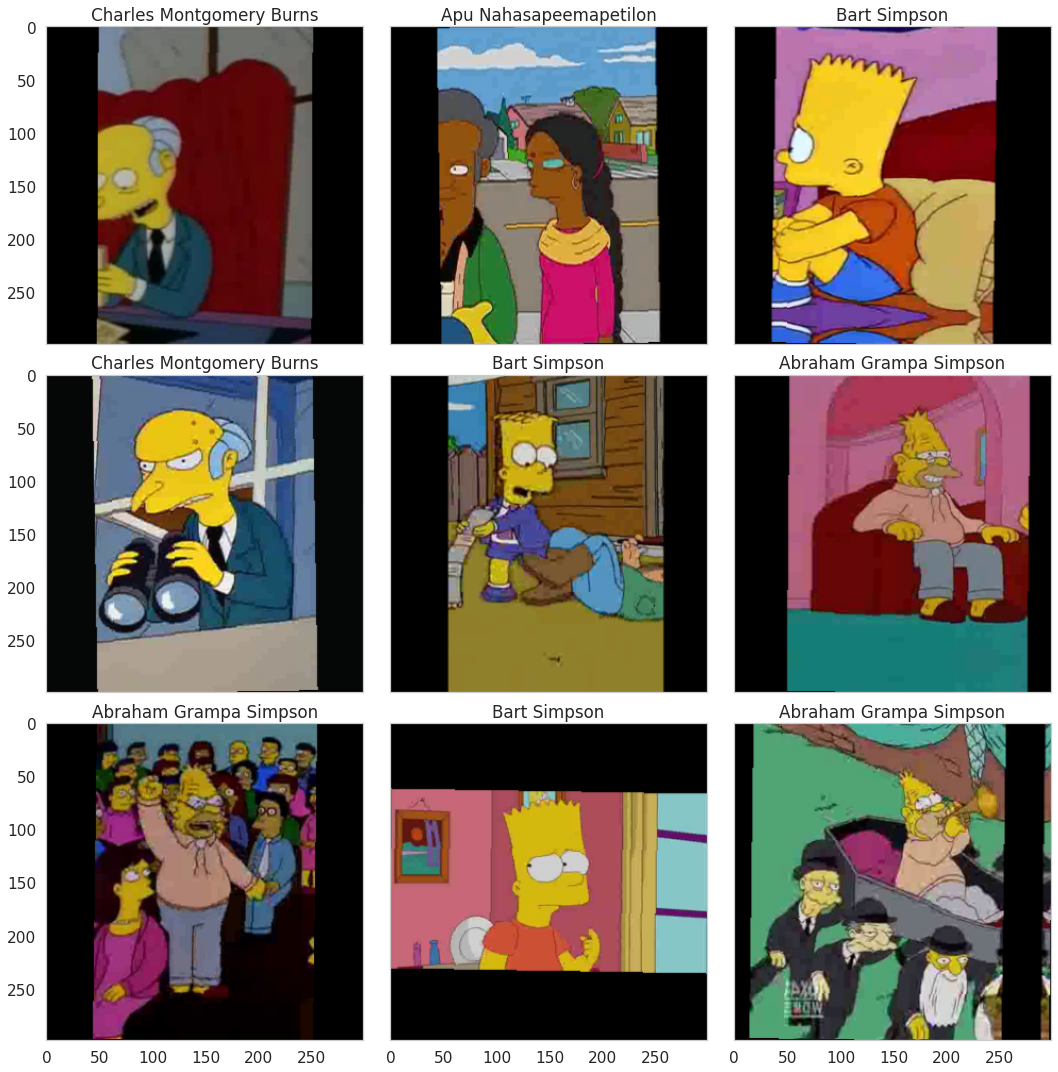

In [ ]:
# Рисуем 9 рандомных объектов
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
plt.tight_layout()
plt.show()

In [ ]:
# Поиск эффективного lr для модели
logs, losses = find_lr(model=model, dataloaders={"train":train_loader}, loss_fn=nn.CrossEntropyLoss(), 
        optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True), classic=False)

index = losses.index(min(losses))
found_lr = logs[index]
found_lr = 10**found_lr

Text(0, 0.5, 'loss')

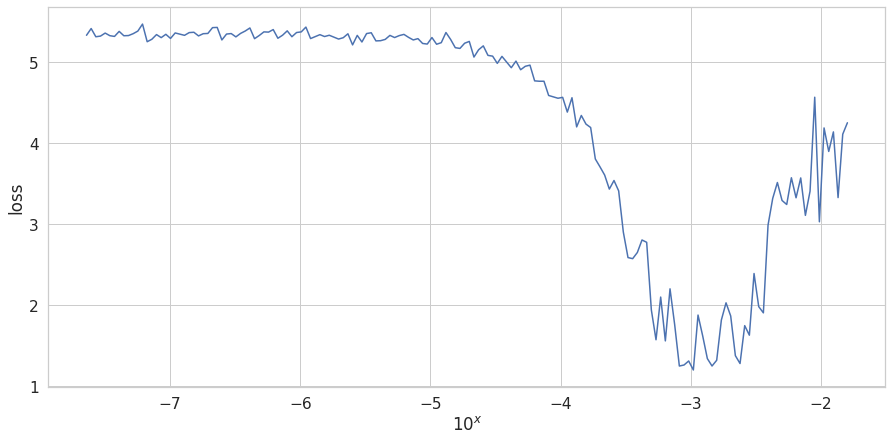

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
# определение оптимайзера для модели
opt = optimizer(model=model, found_lr=found_lr, mode="inception")

In [ ]:
# Обучаем модель
history = train(train_dataset, val_dataset, model=model, epochs=21, batch_size=100, opt=opt, classic=False)

epoch:   0%|          | 0/21 [00:00<?, ?it/s]

loss 1.2648092953317722


epoch:   5%|▍         | 1/21 [05:40<1:53:24, 340.24s/it]


Epoch 001 train_loss: 1.2648     val_loss 0.3287 train_acc 0.7787 val_acc 0.9127
loss 0.3270395704499104


epoch:  10%|▉         | 2/21 [11:11<1:46:51, 337.46s/it]


Epoch 002 train_loss: 0.3270     val_loss 0.2431 train_acc 0.9449 val_acc 0.9380
loss 0.16606338725466196


epoch:  14%|█▍        | 3/21 [16:44<1:40:53, 336.32s/it]


Epoch 003 train_loss: 0.1661     val_loss 0.2237 train_acc 0.9745 val_acc 0.9444
loss 0.10245280211948041


epoch:  19%|█▉        | 4/21 [22:15<1:34:49, 334.68s/it]


Epoch 004 train_loss: 0.1025     val_loss 0.2159 train_acc 0.9857 val_acc 0.9496
loss 0.07787375803436151


epoch:  24%|██▍       | 5/21 [27:47<1:29:03, 333.94s/it]


Epoch 005 train_loss: 0.0779     val_loss 0.2237 train_acc 0.9877 val_acc 0.9509
loss 0.0662593572069892


epoch:  29%|██▊       | 6/21 [33:21<1:23:26, 333.77s/it]


Epoch 006 train_loss: 0.0663     val_loss 0.2019 train_acc 0.9896 val_acc 0.9516
loss 0.047226220771406494


epoch:  33%|███▎      | 7/21 [38:47<1:17:21, 331.55s/it]


Epoch 007 train_loss: 0.0472     val_loss 0.2265 train_acc 0.9913 val_acc 0.9520
loss 0.029043073761428232


epoch:  38%|███▊      | 8/21 [44:11<1:11:19, 329.20s/it]


Epoch 008 train_loss: 0.0290     val_loss 0.1912 train_acc 0.9958 val_acc 0.9576
loss 0.02049826246267404


epoch:  43%|████▎     | 9/21 [49:33<1:05:24, 327.08s/it]


Epoch 009 train_loss: 0.0205     val_loss 0.1892 train_acc 0.9979 val_acc 0.9576
loss 0.016214987866213594


epoch:  48%|████▊     | 10/21 [54:54<59:39, 325.39s/it]


Epoch 010 train_loss: 0.0162     val_loss 0.1778 train_acc 0.9984 val_acc 0.9617
loss 0.015986328327167003


epoch:  52%|█████▏    | 11/21 [1:00:18<54:07, 324.71s/it]


Epoch 011 train_loss: 0.0160     val_loss 0.1865 train_acc 0.9983 val_acc 0.9596
loss 0.014703000463403003


epoch:  57%|█████▋    | 12/21 [1:05:43<48:43, 324.80s/it]


Epoch 012 train_loss: 0.0147     val_loss 0.1866 train_acc 0.9984 val_acc 0.9606
loss 0.013302414537044956


epoch:  62%|██████▏   | 13/21 [1:11:08<43:20, 325.07s/it]


Epoch 013 train_loss: 0.0133     val_loss 0.1723 train_acc 0.9988 val_acc 0.9613
loss 0.012686298024214303


epoch:  67%|██████▋   | 14/21 [1:16:35<37:58, 325.51s/it]


Epoch 014 train_loss: 0.0127     val_loss 0.1754 train_acc 0.9984 val_acc 0.9620
loss 0.0111573601902387


epoch:  71%|███████▏  | 15/21 [1:22:08<32:46, 327.81s/it]


Epoch 015 train_loss: 0.0112     val_loss 0.1804 train_acc 0.9991 val_acc 0.9598
loss 0.010944882935191212


epoch:  76%|███████▌  | 16/21 [1:27:36<27:19, 327.99s/it]


Epoch 016 train_loss: 0.0109     val_loss 0.1706 train_acc 0.9991 val_acc 0.9611
loss 0.011157092909381548


epoch:  81%|████████  | 17/21 [1:33:06<21:54, 328.52s/it]


Epoch 017 train_loss: 0.0112     val_loss 0.1692 train_acc 0.9990 val_acc 0.9602
loss 0.009842744250986305


epoch:  86%|████████▌ | 18/21 [1:38:40<16:30, 330.13s/it]


Epoch 018 train_loss: 0.0098     val_loss 0.1761 train_acc 0.9991 val_acc 0.9622
loss 0.011246321231645009


epoch:  90%|█████████ | 19/21 [1:44:01<10:54, 327.43s/it]


Epoch 019 train_loss: 0.0112     val_loss 0.1836 train_acc 0.9989 val_acc 0.9604
loss 0.010367451759737517


epoch:  95%|█████████▌| 20/21 [1:49:18<05:24, 324.19s/it]


Epoch 020 train_loss: 0.0104     val_loss 0.1818 train_acc 0.9992 val_acc 0.9619
loss 0.011004424791849403


epoch: 100%|██████████| 21/21 [1:54:43<00:00, 327.77s/it]


Epoch 021 train_loss: 0.0110     val_loss 0.1748 train_acc 0.9985 val_acc 0.9611


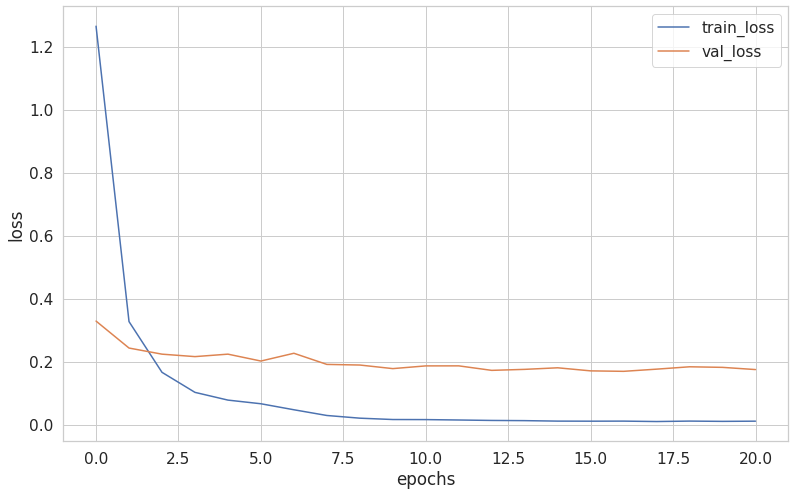

In [ ]:
# кривые валидации
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(13, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# сохраняем модель 
PATH = "gdrive/My Drive/nn/" + model_names[2] + "/model_weights.pth"
torch.save(model.state_dict(), PATH) 

In [ ]:
# предсказываем для трейна
probs, y_preds, real_y = predict(model=model, loader=train_loader, mode="train")

def listmerge3(lstlst):
    all=[]
    for lst in lstlst:
      all.extend(lst)
    return all
real = np.array(listmerge3(real_y))

errors_list = np.array(range(y_preds.shape[0]))[y_preds!=real]
print(len(errors_list))

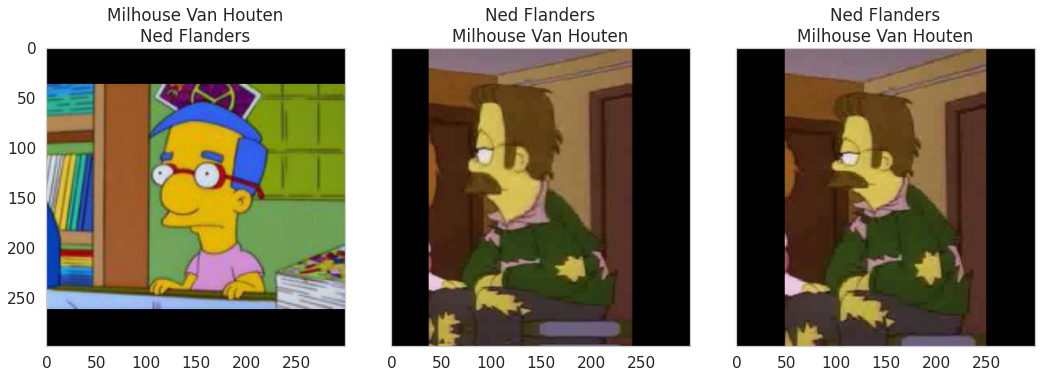

In [ ]:
# Рисуем ошибочные объекты на трейне
# чет тут кажись не то, в accurancy_for_each_class другие ошибки
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15, 5), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    error_character_index = int(np.random.uniform(0,errors_list.shape[0]))
    error_character = errors_list[error_character_index]
    im_val, label = train_dataset[error_character]
    label_pred =  y_preds[error_character_index]
    # label_pred = train_dataset.label_encoder.inverse_transform([label_pred])[0]
    label_pred = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label_pred])[0].split('_')))
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label + "\n" + label_pred,plt_ax=fig_x)
plt.tight_layout()
plt.show()

In [ ]:
# accurancy_for_each_class для трейна
accurancy_for_each_class(y_test_all=real, predictions_all=y_preds, loader=train_loader)

[685, 56, 467, 80, 1006, 74, 895, 740, 56, 352, 56, 343, 56, 56, 91, 1683, 374, 905, 233, 56, 1015, 96, 969, 56, 185, 809, 56, 1090, 1090, 269, 56, 56, 897, 56, 56, 67, 77, 658, 56, 56, 56, 134]
42
Accuracy of abraham_grampa_simpson : 100 %
Accuracy of agnes_skinner : 100 %
Accuracy of apu_nahasapeemapetilon : 100 %
Accuracy of barney_gumble : 100 %
Accuracy of bart_simpson : 100 %
Accuracy of carl_carlson : 100 %
Accuracy of charles_montgomery_burns : 100 %
Accuracy of chief_wiggum : 100 %
Accuracy of cletus_spuckler : 100 %
Accuracy of comic_book_guy : 100 %
Accuracy of disco_stu : 100 %
Accuracy of edna_krabappel : 100 %
Accuracy of fat_tony : 100 %
Accuracy of   gil : 100 %
Accuracy of groundskeeper_willie : 100 %
Accuracy of homer_simpson : 100 %
Accuracy of kent_brockman : 100 %
Accuracy of krusty_the_clown : 100 %
Accuracy of lenny_leonard : 100 %
Accuracy of lionel_hutz : 100 %
Accuracy of lisa_simpson : 100 %
Accuracy of maggie_simpson : 100 %
Accuracy of marge_simpson : 99 %


In [ ]:
# предсказываем для val 
probs, y_preds, real_y = predict(model=model, loader=val_loader, mode="train")

def listmerge3(lstlst):
    all=[]
    for lst in lstlst:
      all.extend(lst)
    return all
real = np.array(listmerge3(real_y))

errors_list = np.array(range(y_preds.shape[0]))[y_preds!=real]
print(len(errors_list))

199


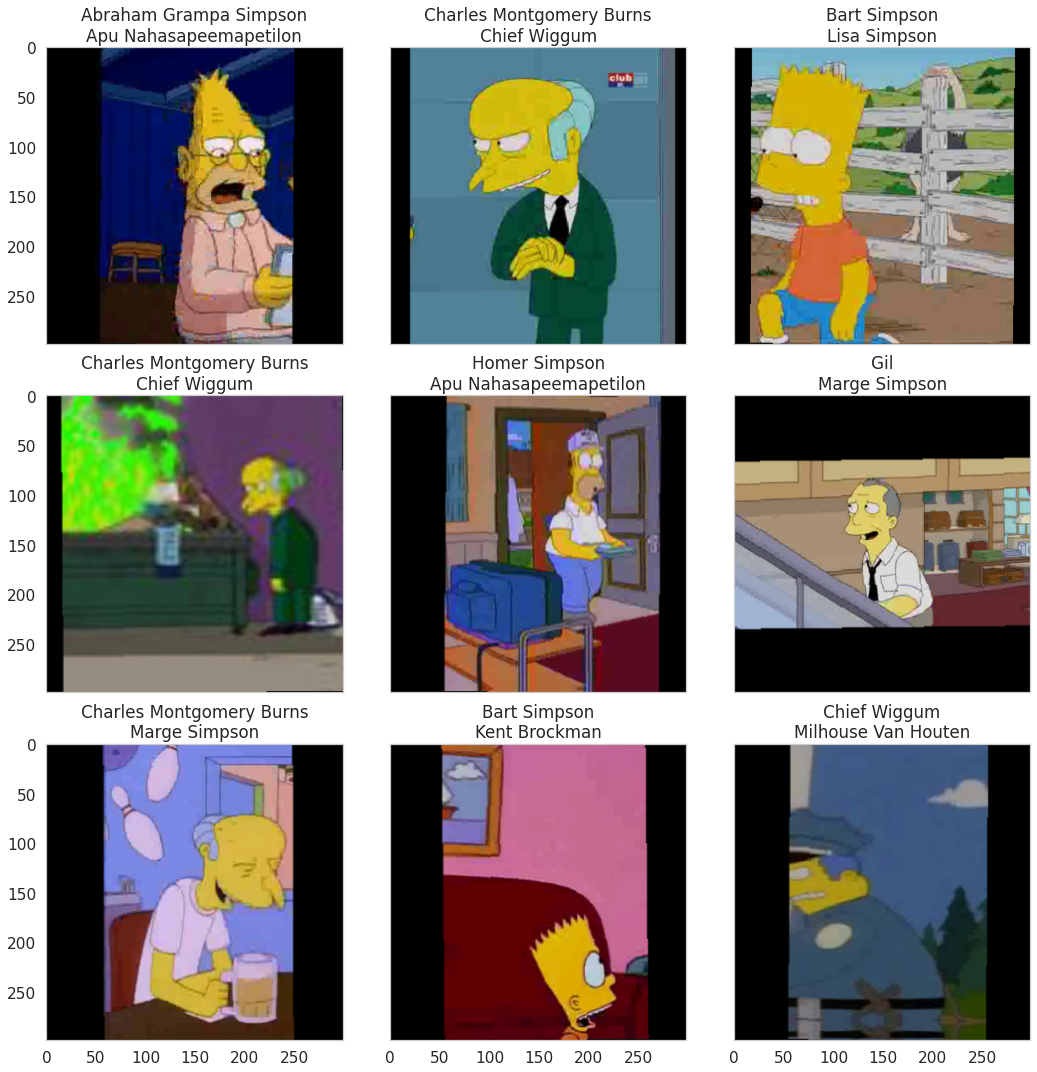

In [ ]:
# Рисуем ошибочные объекты на вал
# чет тут кажись не то, в accurancy_for_each_class другие ошибки
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    error_character_index = int(np.random.uniform(0,errors_list.shape[0]))
    error_character = errors_list[error_character_index]
    im_val, label = train_dataset[error_character]
    label_pred =  y_preds[error_character_index]
    # label_pred = train_dataset.label_encoder.inverse_transform([label_pred])[0]
    label_pred = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label_pred])[0].split('_')))
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label + "\n" + label_pred,plt_ax=fig_x)
plt.tight_layout()
plt.show()

In [ ]:
# выгрузка результатов
# inception = 0.98512
# efnet = 0.98512
probs, y_preds = predict(model, test_loader, mode="test")
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

PATH = "gdrive/My Drive/nn/" + model_names[2] + "/model_results.csv"
my_submit.to_csv(PATH, index=False)

In [ ]:
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


## Обучение сети до добавления аугментаций и прочего
обучил efnet на дефолтном ноутбуке, а качество такое же как на inception с кучей правок:(

In [ ]:
# Сетевые настройки
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=len(np.unique(train_val_labels)))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


In [ ]:
eff_net = model.to(DEVICE)

In [ ]:
# Определяем датасеты
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
# Обучаем модель
history = train(train_dataset, val_dataset, model=eff_net, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 3.126834485141918


epoch:  10%|█         | 1/10 [03:50<34:32, 230.28s/it]


Epoch 001 train_loss: 3.1268     val_loss 2.4243 train_acc 0.5238 val_acc 0.8152
loss 0.9988961430581271


epoch:  20%|██        | 2/10 [07:39<30:38, 229.83s/it]


Epoch 002 train_loss: 0.9989     val_loss 0.6474 train_acc 0.8460 val_acc 0.8785
loss 0.44710460805051594


epoch:  30%|███       | 3/10 [11:26<26:43, 229.07s/it]


Epoch 003 train_loss: 0.4471     val_loss 0.3957 train_acc 0.9132 val_acc 0.9209
loss 0.32629376220922574


epoch:  40%|████      | 4/10 [15:16<22:57, 229.50s/it]


Epoch 004 train_loss: 0.3263     val_loss 0.3261 train_acc 0.9352 val_acc 0.9287
loss 0.24429968746462188


epoch:  50%|█████     | 5/10 [19:06<19:06, 229.39s/it]


Epoch 005 train_loss: 0.2443     val_loss 0.3326 train_acc 0.9503 val_acc 0.9316
loss 0.20544741680739192


epoch:  60%|██████    | 6/10 [22:55<15:18, 229.53s/it]


Epoch 006 train_loss: 0.2054     val_loss 0.2611 train_acc 0.9570 val_acc 0.9440
loss 0.09850307445942547


epoch:  70%|███████   | 7/10 [26:48<11:31, 230.52s/it]


Epoch 007 train_loss: 0.0985     val_loss 0.1693 train_acc 0.9798 val_acc 0.9620
loss 0.06608860405875404


epoch:  80%|████████  | 8/10 [30:40<07:41, 230.77s/it]


Epoch 008 train_loss: 0.0661     val_loss 0.1610 train_acc 0.9862 val_acc 0.9654
loss 0.0544024448277286


epoch:  90%|█████████ | 9/10 [34:31<03:50, 230.96s/it]


Epoch 009 train_loss: 0.0544     val_loss 0.1562 train_acc 0.9896 val_acc 0.9660
loss 0.04577336487690524


epoch: 100%|██████████| 10/10 [38:21<00:00, 230.20s/it]


Epoch 010 train_loss: 0.0458     val_loss 0.1500 train_acc 0.9912 val_acc 0.9660
